# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name: Erfan Falahati**
- **Student ID: 810102491**

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

In [70]:
import math
import torch
import pickle
import random
import numpy as np
import torchvision
import torch.nn as nn
from functools import partial
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split




plt.style.use('seaborn-v0_8')

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [71]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# GOOGLE_DRIVE_PATH = '/content/drive/My Drive/AIS25-CA4'
# os.makedirs(GOOGLE_DRIVE_PATH, exist_ok=True)
# os.chdir(GOOGLE_DRIVE_PATH)


## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [73]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [74]:

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [75]:
batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

### **Why we use dataloader ?**
- `Dataset` just defines how to access the data.
- `DataLoader` provides efficient ways to load, batch, shuffle, and parallelize data loading.

Advantages of `DataLoader` Over Just Using `Dataset`:

| Feature | Description |
|--------|-------------|
| **1. Automatic Batching** | With `batch_size`, you can load data in mini-batches (e.g., 64 samples at a time), which is essential for training neural networks efficiently. |
| **2. Easy Shuffling** | You can set `shuffle=True` to randomly shuffle your data at the beginning of each epoch, which helps prevent overfitting. |
| **3. Multi-Processing Support** | With `num_workers > 0`, the `DataLoader` can use multiple subprocesses to load data in parallel, **speeding up training significantly**. |
| **4. Pin Memory & Prefetching** | When using a GPU, setting `pin_memory=True` helps transfer data to GPU faster. Also, `DataLoader` can prefetch batches in advance while your model is training. |
| **5. Simplifies Training Loops** | `DataLoader` is iterable, so you can loop over batches easily using `for batch in loader:`. This structure makes training code clean and efficient. |

---

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [76]:
# inverse the normilize transform to restore the original data

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        tensor = tensor * self.std + self.mean

        if gray:
            r, g, b = tensor[0], tensor[1], tensor[2]
            gray_tensor = coeff[0] * r + coeff[1] * g + coeff[2] * b
            return gray_tensor.unsqueeze(0)

        return tensor

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

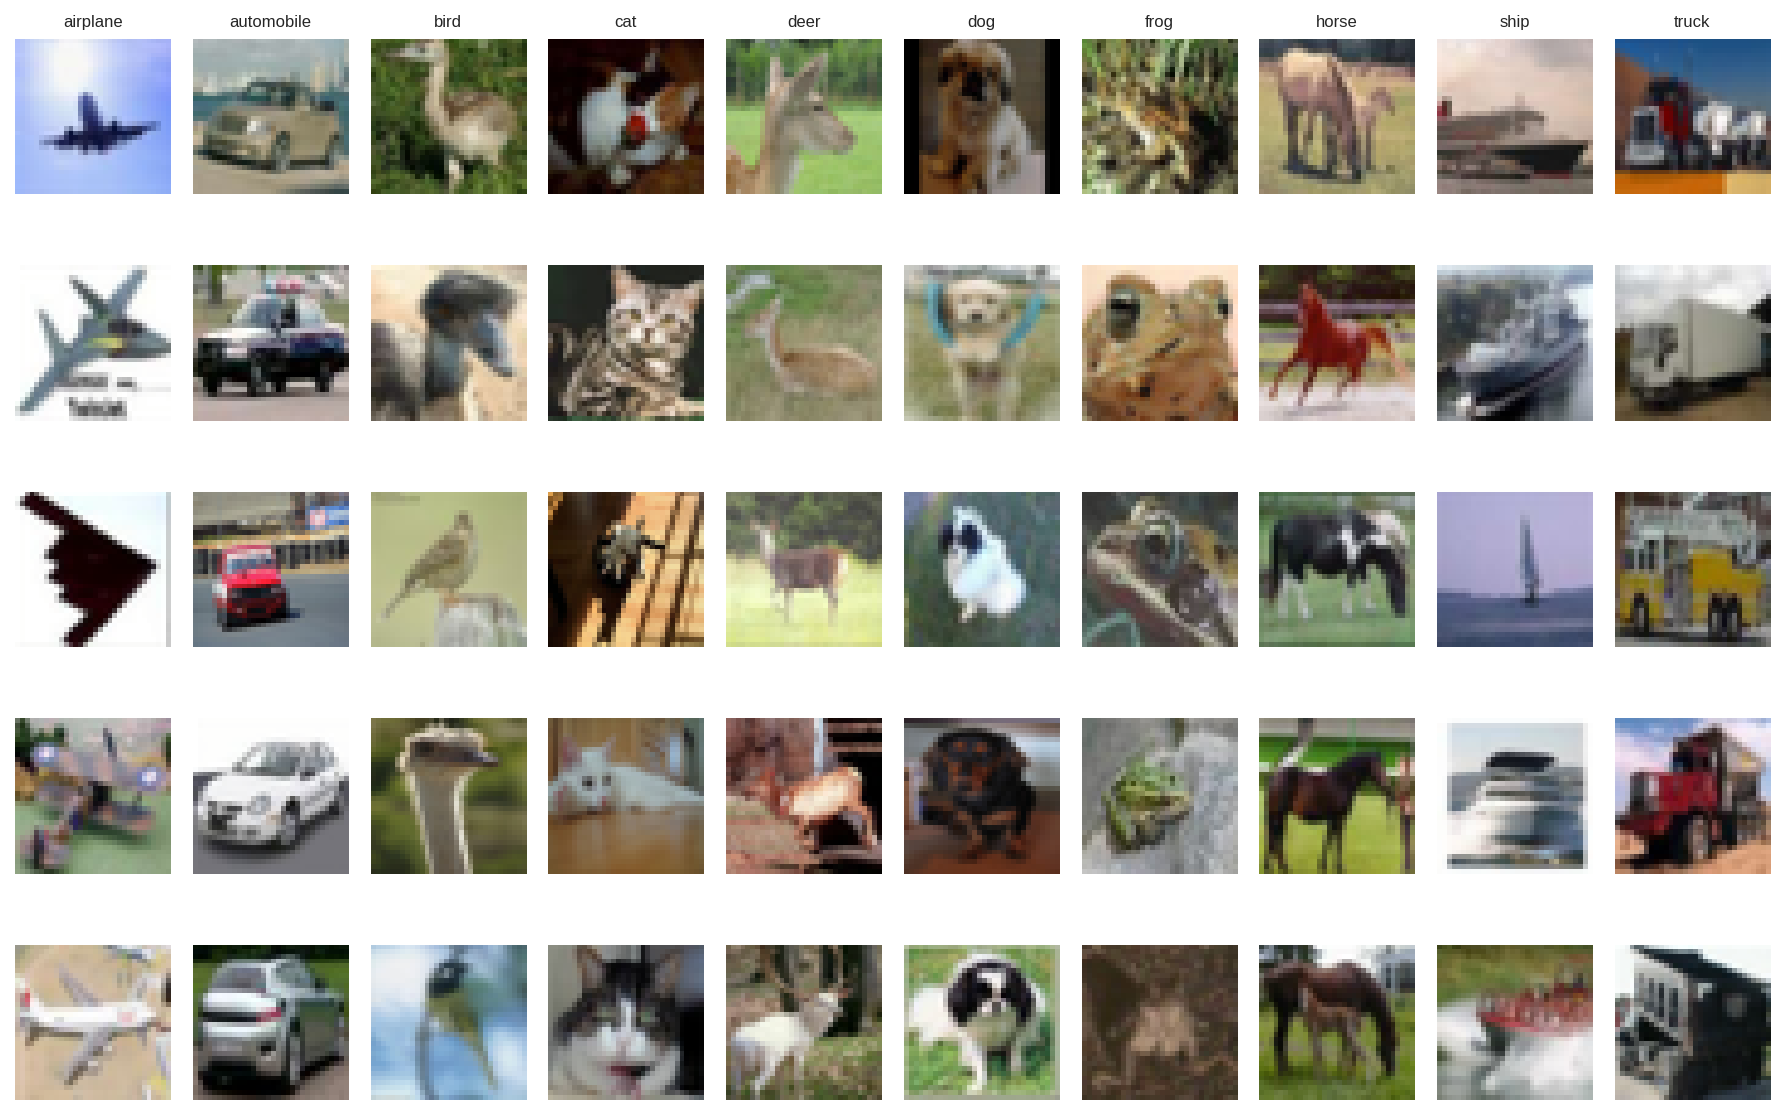

In [77]:
all_images = []
all_labels = []
for images, labels in DataLoader(trainset, batch_size=len(trainset)):
    all_images = images
    all_labels = labels
    break

class_samples = {i: [] for i in range(10)}
for img, label in zip(all_images, all_labels):
    if len(class_samples[label.item()]) < 5:
        class_samples[label.item()].append(img)
    if all(len(samples) == 5 for samples in class_samples.values()):
        break

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(12, 8))
for col, (class_id, images) in enumerate(class_samples.items()):
    for row in range(5):
        img = norminv(images[row])
        img = img.permute(1, 2, 0).numpy()
        axes[row][col].imshow(np.clip(img, 0, 1))
        axes[row][col].axis('off')
        if row == 0:
            axes[row][col].set_title(class_names[class_id], fontsize=8)

plt.tight_layout()
plt.show()



# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [78]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10, hidden_dims=(2048, 8192, 1300), dropout=0.3):
        super(FullyConnectedNetwork, self).__init__()

        input_dim = input_shape[0] * input_shape[1] * input_shape[2]

        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.linear = nn.Linear(hidden_dims[2], num_classes)


    def forward(self, x):
        x = self.network(x)
        x = self.linear(x)
        return x

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

$$
\begin{aligned}
\text{total} =\ & (3 \times 32 \times 32 \times 2048 + 2048) \\
&+ (2048 \times 8192 + 8192) \\
&+ (8192 \times 1300 + 1300) \\
&+ (1300 \times 10 + 10) \\
=\ & 33,\!742,\!822
\end{aligned}
$$

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [79]:
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 2048]       6,293,504
              ReLU-3                 [-1, 2048]               0
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 8192]      16,785,408
              ReLU-6                 [-1, 8192]               0
           Dropout-7                 [-1, 8192]               0
            Linear-8                 [-1, 1300]      10,650,900
              ReLU-9                 [-1, 1300]               0
          Dropout-10                 [-1, 1300]               0
           Linear-11                   [-1, 10]          13,010
Total params: 33,742,822
Trainable params: 33,742,822
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [80]:
model = FullyConnectedNetwork()
model.to(device)
device

'cuda'

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [82]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` updates the model's parameters based on the computed gradients to minimize the loss.
    """
    net.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss, accuracy = running_loss / total, 100 * correct / total
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


    avg_loss, accuracy = running_loss / total, 100 * correct / total
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [83]:
# epochs = 60 # Do not modify

# history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


# for epoch in range(epochs):
#     train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
#     val_loss, val_acc = eval_epoch(model, criterion, valloader)

#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)

#     print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [84]:
# torch.save(model.state_dict(), "fully-connected.pth")
# with open('history.pkl', 'wb') as f:
#     pickle.dump(history, f)

In [85]:
# # # To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('content/fully-connected .pth', map_location=torch.device('cpu')))
with open('content/history_fcn.pkl', 'rb') as f:
    history = pickle.load(f)

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

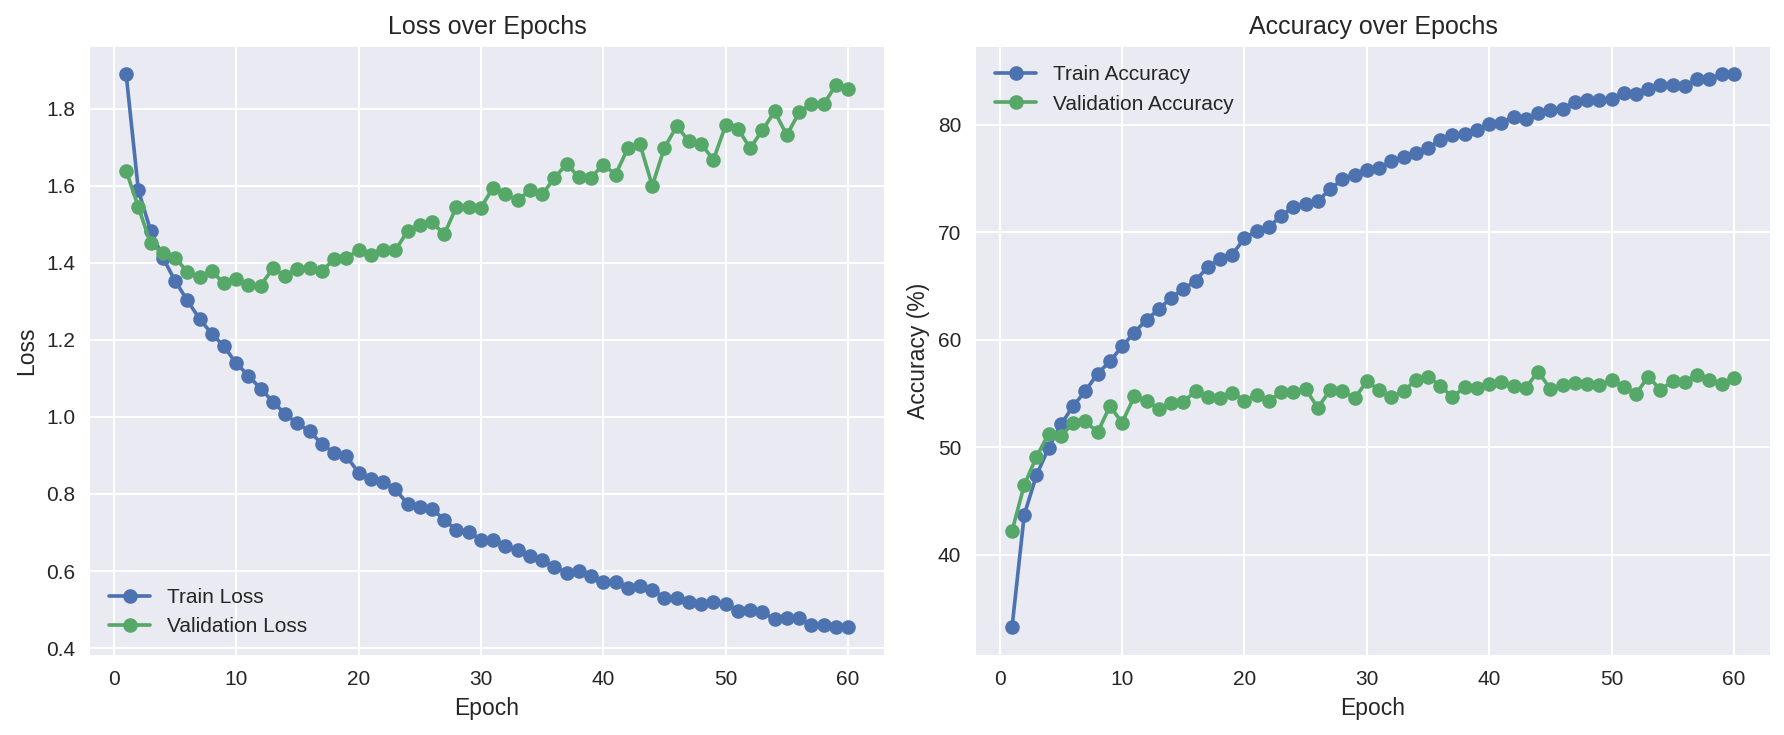

In [86]:
import matplotlib.pyplot as plt

train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [87]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 56.82%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

batch_size = 512

initial_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

# Override valset transform to remove augmentation
valset.dataset.transform = transform_test

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [89]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        Conv = partial(nn.Conv2d, kernel_size=3, stride=1, padding=1)

        self.conv_layers = nn.Sequential(
            Conv(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            Conv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            Conv(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),

            Conv(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),

            Conv(512, 1024),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Dropout2d(0.4),

            Conv(1024, 1024),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()

        self.feature_layer = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.hidden = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        features = self.feature_layer(x)
        x = self.hidden(features)
        out = self.classifier(x)
        return out, features


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

$$
\begin{aligned}
\text{total} =\ & (3 \times 64 \times 3 \times 3 + 64) \\
&+ 128 \\
&+ (64 \times 128 \times 3 \times 3 + 128) \\
&+ 256 \\
&+ (128 \times 256 \times 3 \times 3 + 256) \\
&+ 512 \\
&+ (256 \times 512 \times 3 \times 3 + 512) \\
&+ 1024 \\
&+ (512 \times 1024 \times 3 \times 3 + 1024) \\
&+ 2048 \\
&+ (1024 \times 1024 \times 3 \times 3 + 1024) \\
&+ 2048 \\
&+ (1024 \times 4 \times 4 \times 1024 + 1024) \\
&+ 2048 \\
&+ (1024 \times 1024 + 1024) \\
&+ 2048 \\
&+ (1024 \times 10 + 10) \\
=\ & 33,\!557,\!002
\end{aligned}
$$


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [90]:
summary(CNN().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         Dropout2d-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
             ReLU-12          [-1, 256, 16, 16]               0
        Dropout2d-13          [-1, 256, 16, 16]               0
           Conv2d-14          [-1, 512,

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [91]:
model = CNN()
model.to(device)
device

device(type='cuda')

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [93]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits, _ = net(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss, accuracy = running_loss / total, 100 * correct / total
    return avg_loss, accuracy


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits, _ = net(inputs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [94]:
# epochs = 60 # Do not modify
# history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# for epoch in range(epochs):
#     train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
#     val_loss, val_acc = eval_epoch(model, criterion, valloader)

#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
#     scheduler.step()

#     print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [95]:
# torch.save(model.state_dict(), "cnn.pth")
# with open('history_cnn.pkl', 'wb') as f:
#     pickle.dump(history, f)

In [96]:
# To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('content/cnn.pth', map_location=torch.device('cpu')))
with open('content/history_cnn.pkl', 'rb') as f:
    history = pickle.load(f)

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

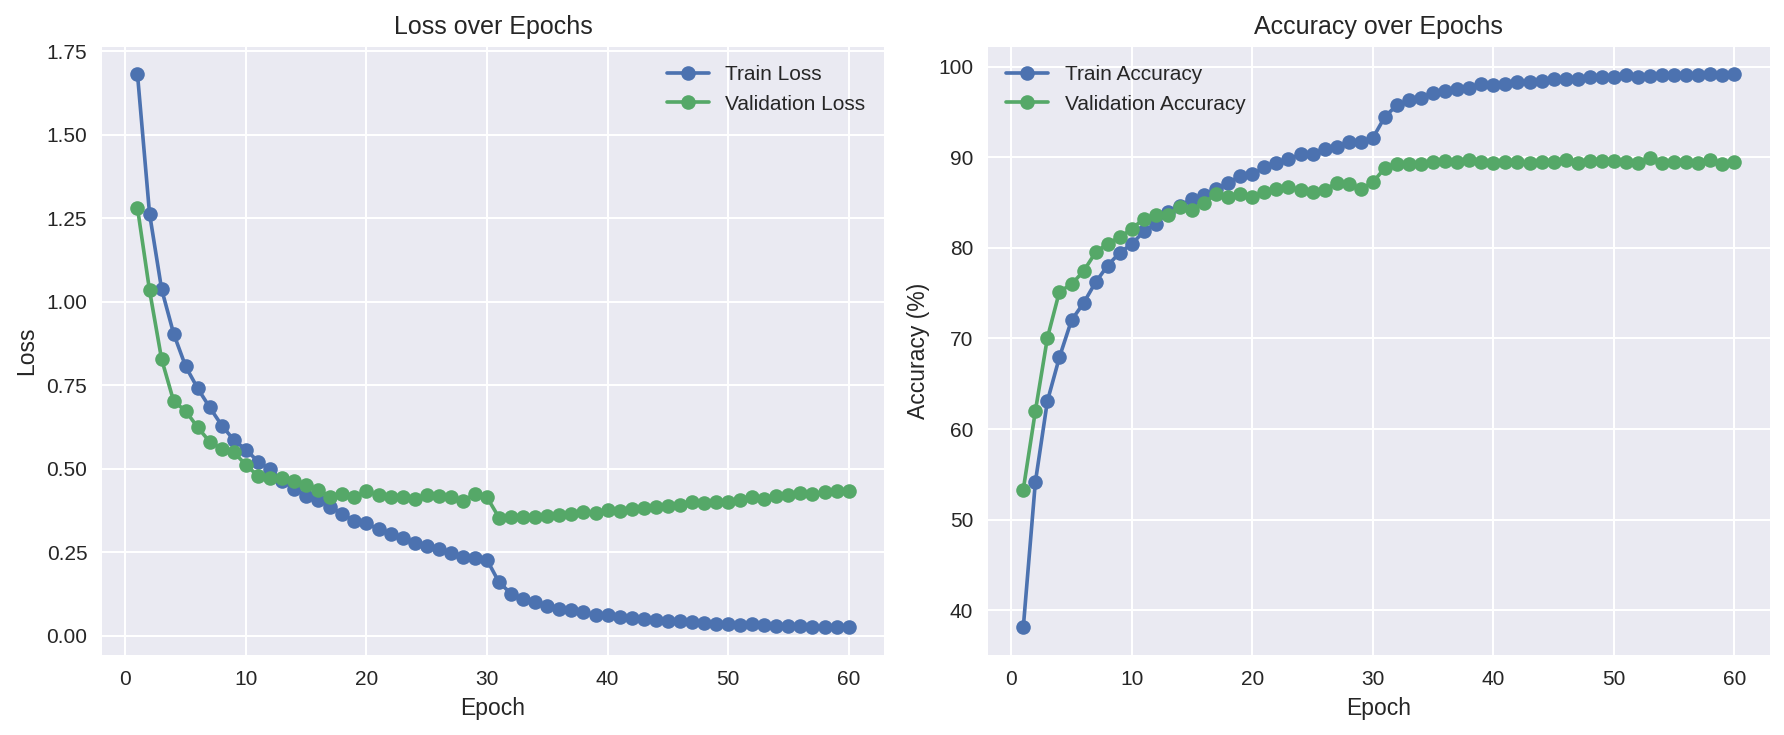

In [97]:
train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [98]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits, _ = model(inputs)

        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 88.29%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

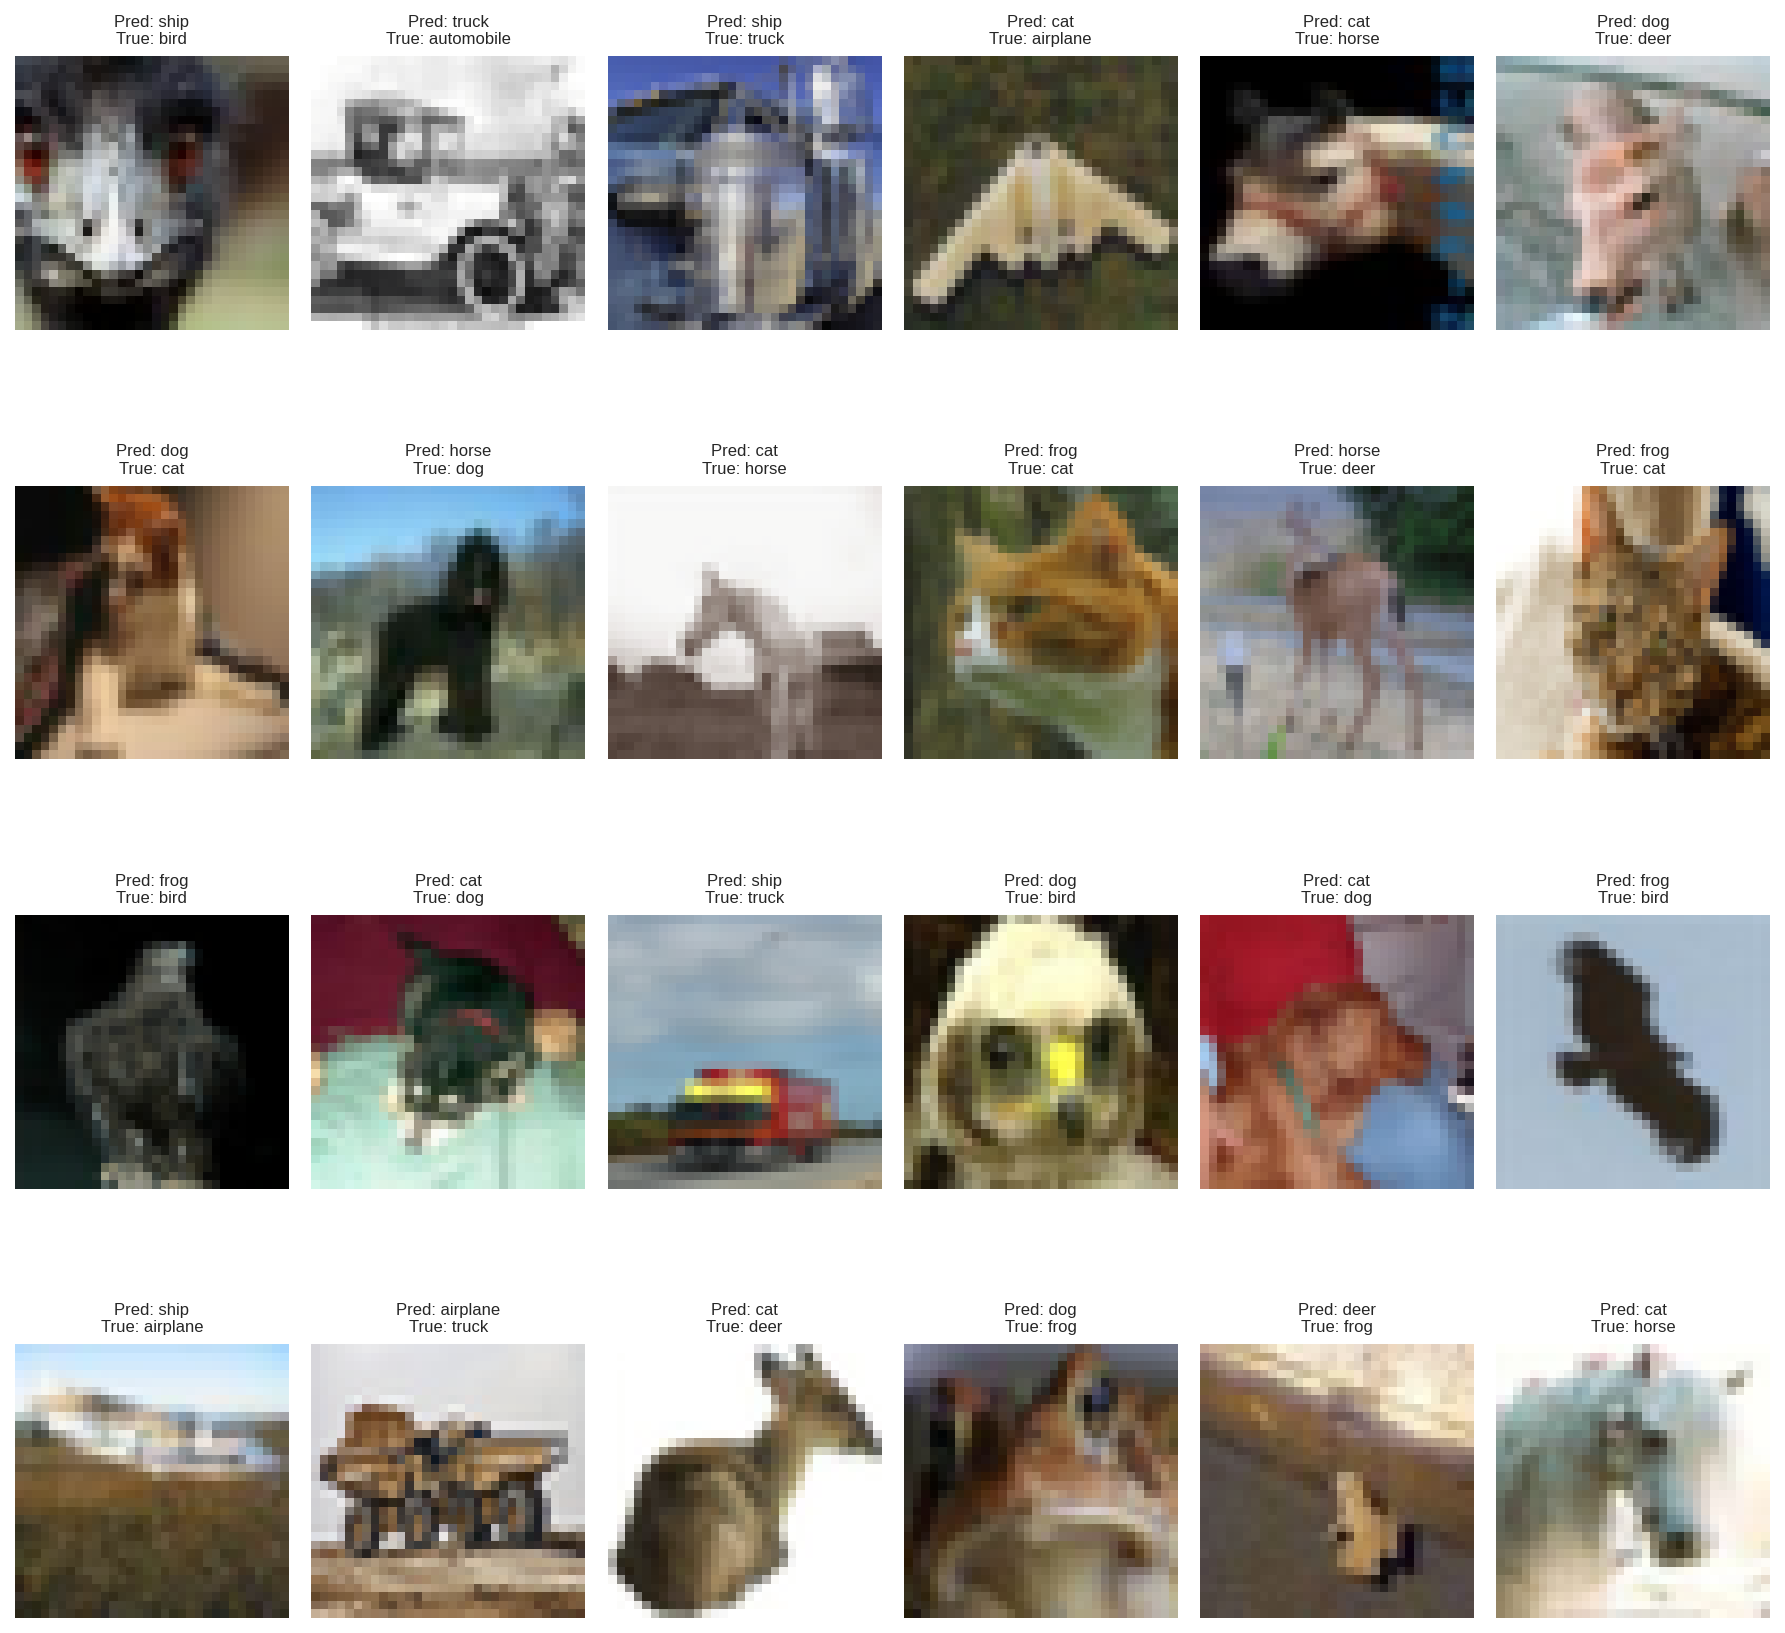

In [99]:
classes = [ 'airplane', 'automobile', 'bird', 'cat',
               'deer','dog', 'frog', 'horse', 'ship', 'truck']

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

model.eval()

incorrect_images = []
incorrect_preds = []
incorrect_labels = []
with torch.no_grad():
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs, _ = model(images)
    _, predicted = outputs.max(1)

    mask = predicted != labels
    incorrect_images.extend(images[mask].cpu())
    incorrect_preds.extend(predicted[mask].cpu())
    incorrect_labels.extend(labels[mask].cpu())

    if len(incorrect_images) >= 24:
      break

incorrect_images = incorrect_images[:24]
incorrect_preds = incorrect_preds[:24]
incorrect_labels = incorrect_labels[:24]

plt.figure(figsize=(12, 12))
for i in range(24):
    img = norminv(incorrect_images[i])
    img = img.permute(1, 2, 0).numpy().clip(0, 1)

    plt.subplot(4, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {classes[incorrect_preds[i]]}\nTrue: {classes[incorrect_labels[i]]}",
              fontsize=8)

plt.tight_layout()
plt.show()



## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [100]:
model.eval()

ordered_trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=False)

features_dim = 1024
feature_space = torch.zeros((45000, features_dim))

start_idx = 0

with torch.no_grad():
    for images, _ in ordered_trainloader:
        images = images.to(device)
        _, features = model(images)
        batch_size = images.size(0)
        feature_space[start_idx:start_idx + batch_size] = features.cpu()
        start_idx += batch_size

feature_space.shape

torch.Size([45000, 1024])

### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

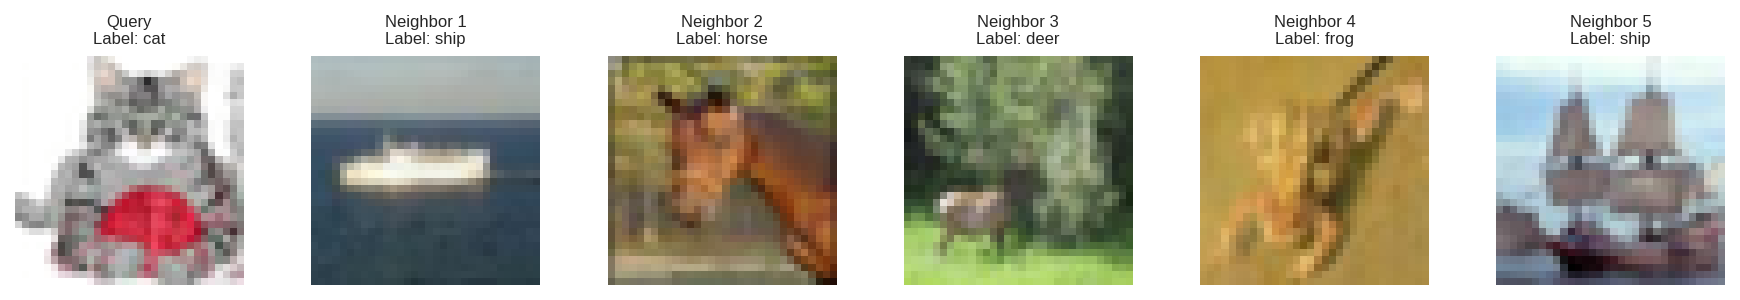

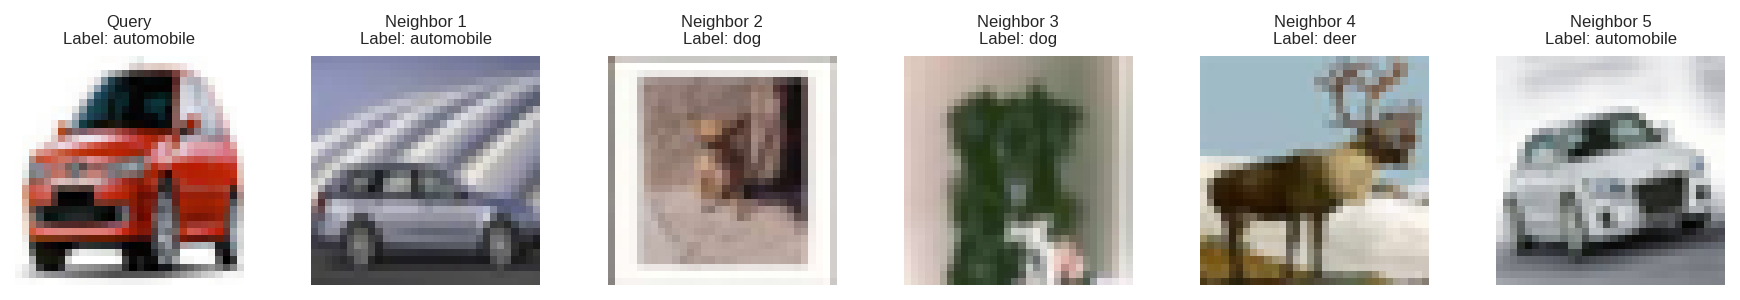

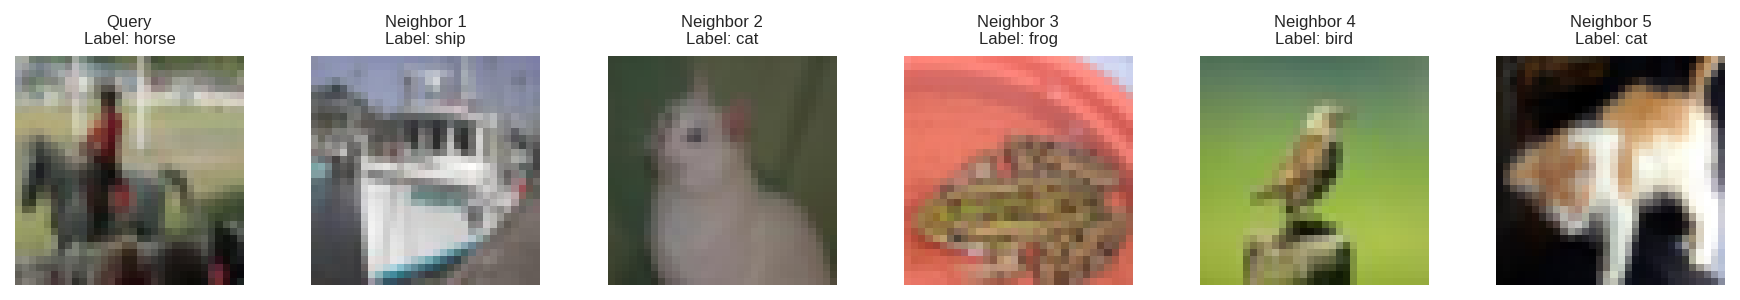

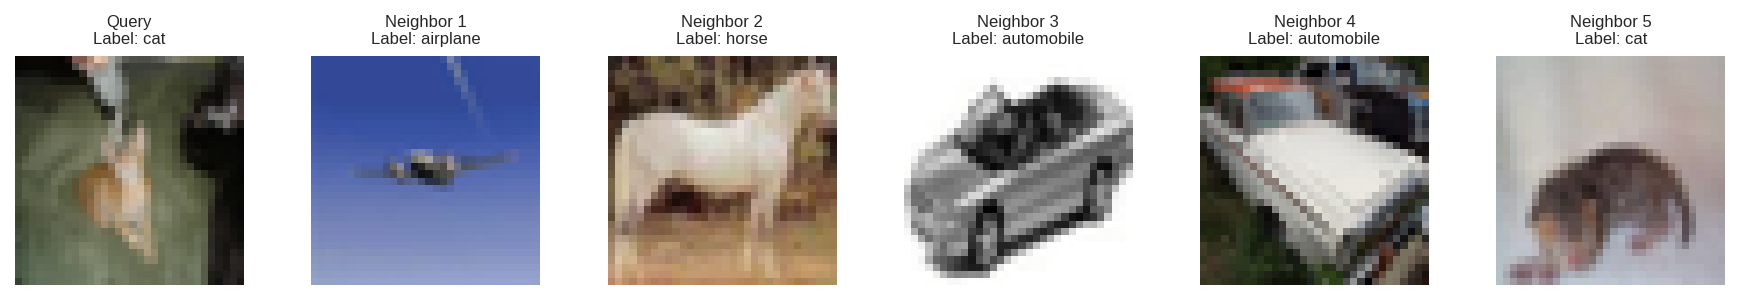

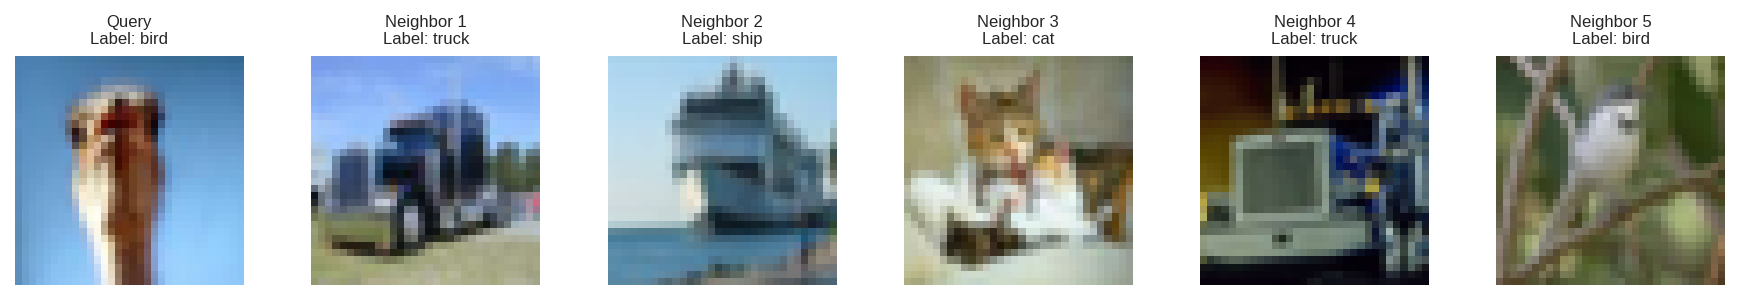

In [101]:
model.eval()

features_spaces = None


classes = [ 'airplane', 'automobile', 'bird', 'cat',
               'deer','dog', 'frog', 'horse', 'ship', 'truck']

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

correct_samples = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = torch.argmax(outputs, dim=1)
        mask = preds == labels
        for i in range(len(images)):
            if mask[i]:
                correct_samples.append((images[i].cpu(), labels[i].item(), preds[i].item()))
        if len(correct_samples) >= 5:
            break

correct_samples = random.sample(correct_samples, 5)

full_trainset = torch.utils.data.Subset(initial_trainset, range(len(initial_trainset)))

def show_images(imgs, titles, nrow=6):
    fig, axs = plt.subplots(1, nrow, figsize=(nrow * 2, 2))
    for i, ax in enumerate(axs):
        img = imgs[i].cpu()
        img = norminv(img)
        img = img.clip(0, 1)

        img = img.permute(1, 2, 0).numpy() 
        ax.imshow(img)
        ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


for img, label, pred in correct_samples:
    img_input = img.unsqueeze(0).to(device)
    with torch.no_grad():
        _, query_feat = model(img_input)

    dists = torch.norm(feature_space.to(device) - query_feat, dim=1)  
    nearest_indices = torch.topk(dists, k=5, largest=False).indices

    neighbors = [full_trainset[idx][0] for idx in nearest_indices]
    neighbor_labels = [full_trainset[idx][1] for idx in nearest_indices]

    show_images([img] + neighbors, 
            [f"Query\nLabel: {classes[label]}"] + 
            [f"Neighbor {j+1}\nLabel: {classes[lbl]}" for j, lbl in enumerate(neighbor_labels)])



### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [102]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
sampled_features = feature_space[indices]
sampled_labels = [initial_trainset[i][1] for i in indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(sampled_features.reshape(sampled_features.shape[0], -1).detach().cpu().numpy())

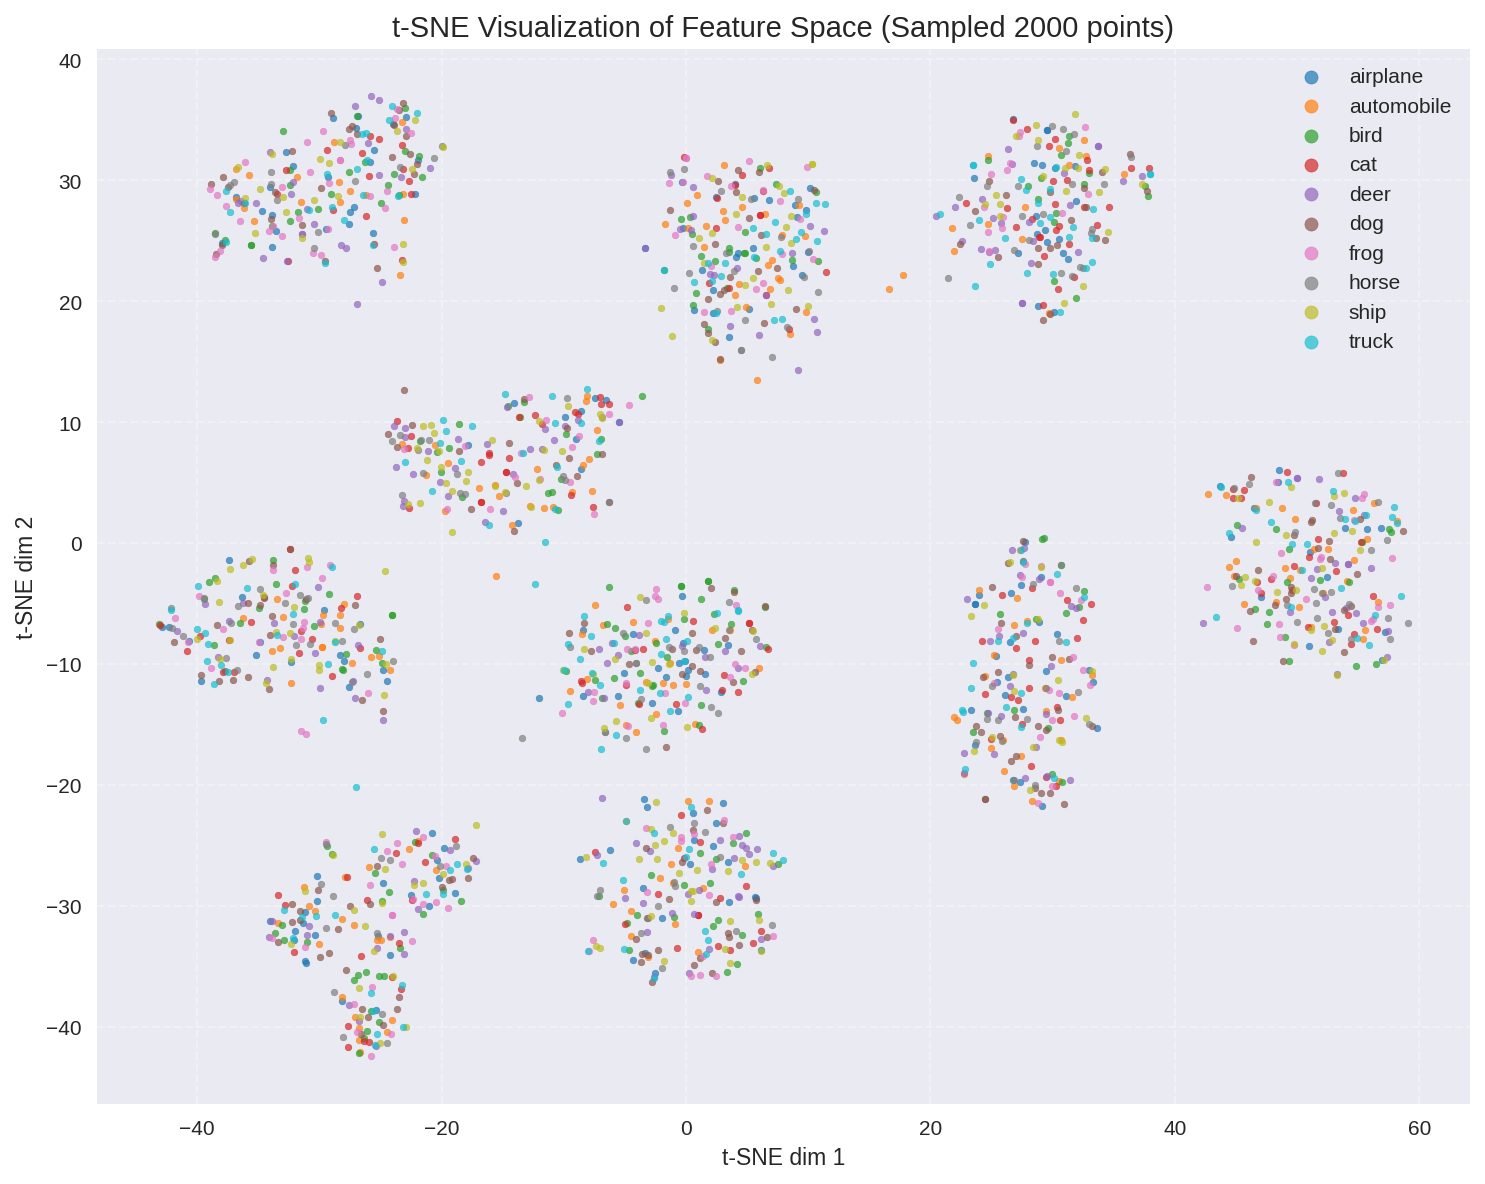

In [103]:
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

plt.figure(figsize=(10, 8))

for class_id in range(len(classes)):
    mask = np.array(sampled_labels) == class_id
    plt.scatter(
        reduced_space[mask, 0],
        reduced_space[mask, 1],
        color=colors[class_id],
        label=classes[class_id],
        s=10, alpha=0.7
    )

plt.legend(markerscale=2)
plt.title("t-SNE Visualization of Feature Space (Sampled 2000 points)", fontsize=14)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [104]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [105]:
input_tensor = image.unsqueeze(0).to(device) 

normalize = transforms.Normalize(mean=(0.491, 0.482, 0.446),
                                 std=(0.247, 0.243, 0.261))
input_tensor = normalize(image).unsqueeze(0).to(device)

clipped = nn.Sequential(*list(model.conv_layers.children())[:4])
clipped.to(device)
clipped.eval()

with torch.no_grad():
    intermediate_output = clipped(input_tensor)


In [106]:
intermediate_output.shape

torch.Size([1, 64, 32, 32])

result shape: torch.Size([1, 64, 32, 32])
result[0].shape: torch.Size([64, 32, 32])
result[0, 0].shape: torch.Size([32, 32])


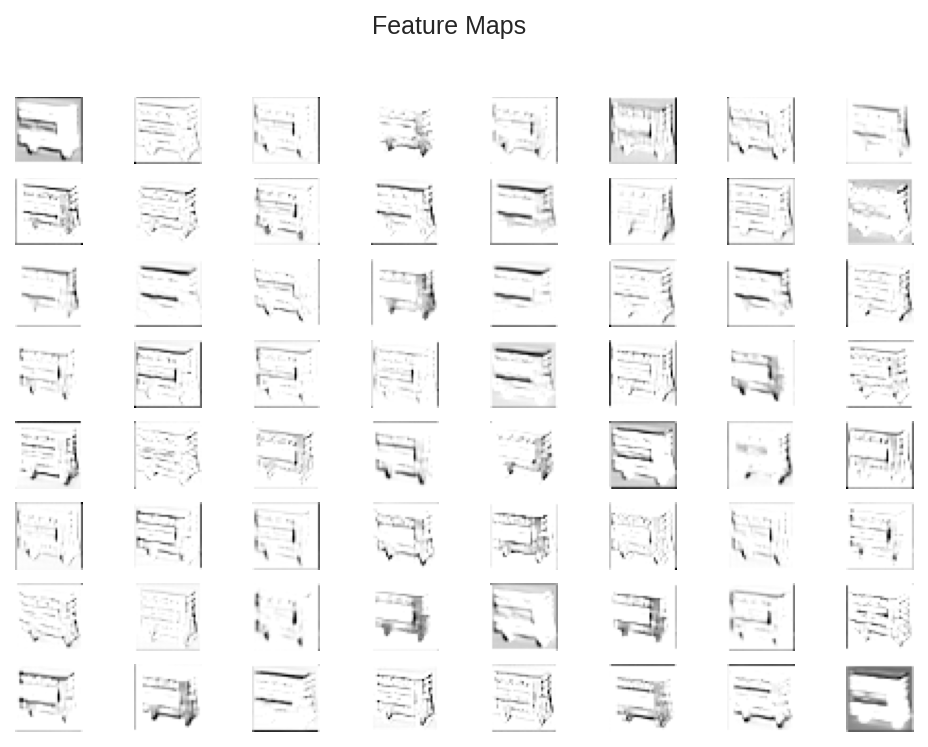

In [107]:
def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    print("result shape:", result.shape)
    print("result[0].shape:", result[0].shape)
    print("result[0, 0].shape:", result[0, 0].shape)


    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
